## Make the domain and map diagram
#### This requires multiple steps so to declutter we put them here

### Set up and add packages

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.interpolate import interpn

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg
import descartes

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.feature as cfeature
#from xgcm import Grid

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw
import time

In [4]:
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Read in data and create the grid

In [8]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

startingidx = np.array([],dtype=int)

# slice the floats by one year
idx_arr = np.empty((2,5460),dtype=int)
x = ds.variables["Xgrid"].values
for i in range(idx_arr.shape[1]):
    # get the indices in that row in the xgrid
    thisrow = x[:,i]
    nonna = thisrow[~np.isnan(thisrow)]
    startidx = len(thisrow)-len(nonna)
    endidx = int(startidx + ((86400/900)*365))
    idx_arr[0][i] = startidx
    idx_arr[1][i] = endidx
    
    
    # see if the start idx
    startingidx = np.append(startingidx,startidx)
    
# select the initial columns of values (at all times)
all_xgrid = ds.variables['Xgrid'].values
all_ygrid = ds.variables['Ygrid'].values
all_salt = ds.variables['salt'].values
all_temp = ds.variables['temp'].values
all_depth = ds.variables['depth'].values
all_dens = ds.variables['rho'].values

# create the new grids of only single year values
xgrid = np.empty((35040,5460))
ygrid = np.empty((35040,5460))
salt = np.empty((35040,5460))
temp = np.empty((35040,5460))
depth = np.empty((35040,5460))
dens = np.empty((35040,5460))
time = np.empty((35040,5460))

# select in the ds.xgrid and ds.ygrid based on the values in the idx_arr
for i in range(idx_arr.shape[1]):
    idxs = idx_arr[:,i]
    thisx = all_xgrid[:,i][idxs[0]:idxs[1]]
    thisy = all_ygrid[:,i][idxs[0]:idxs[1]]
    thissalt = all_salt[:,i][idxs[0]:idxs[1]]
    thistemp = all_temp[:,i][idxs[0]:idxs[1]]
    thisdept = all_depth[:,i][idxs[0]:idxs[1]]
    thisdens = all_dens[:,i][idxs[0]:idxs[1]]
    
    # add these values to our new xgrid and ygrid for one year
    xgrid[:,i] = thisx
    ygrid[:,i] = thisy
    salt[:,i] = thissalt
    temp[:,i] = thistemp
    depth[:,i] = thisdept
    dens[:,i] = thisdens

In [9]:
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values

# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

stack = np.stack((ygrid, xgrid), axis=-1)

lat2 = interpn((ybins,xbins),lat_values,stack)
long2 = interpn((ybins,xbins),long_values,stack)

### Create the schematic

In [36]:
# for the ice shelf plotting and coloring
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('gray',20).copy()
cmap = truncate_colormap(cmap, 0.1)

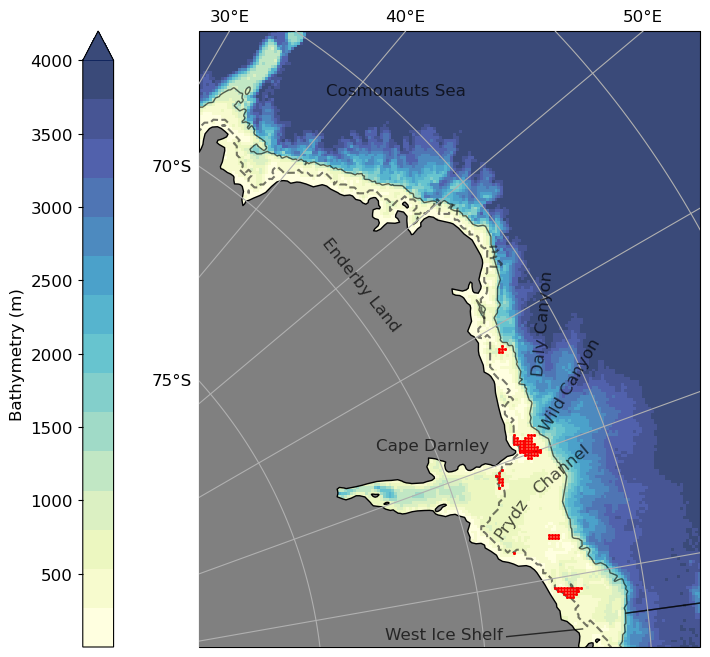

In [48]:
# THESE ARE IN GRID POINTS
########################################
# MAKE THE MAP WITH THE BATHYMETRY
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1, 1, 1,projection=proj)
plt.rcParams.update({'font.size': 12})
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')

# add the bathymetry and ice shelves
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.6)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.2],
            zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=cmap,alpha=0.6)

# add the points and the background pcolormesh
cmap2 = mpl.cm.get_cmap("YlGnBu",15).copy()
plt.scatter(long2[0],lat2[0],transform=ccrs.PlateCarree(),color="red",s=0.05,zorder=10,marker='o')
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),
               cmap=cmap2,alpha=0.8,vmax=4000)

# add the colorbar and lat/long ticks
cbar = plt.colorbar(label="Bathymetry (m)",extend='max',location='left')
gl = ax.gridlines(zorder=3,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.LAND,edgecolor='black', facecolor='gray',zorder=3)
plt.xlim([1250000,3000000])
plt.ylim([200000,2350000])

# add the labels
plt.text(x=52, y=-71.2,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=64.6, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=75.65, y=-69.2,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=73, y=-67.75,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=64.4, y=-66.4,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=68.5, y=-66.9,s="Wild Canyon",transform=ccrs.PlateCarree(),rotation=-300,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=38.5, y=-66,s="Cosmonauts Sea",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.text(x=83.2, y=-73,s="West Ice Shelf",transform=ccrs.PlateCarree(),rotation=0,fontsize=12,alpha=0.7,zorder=4)
plt.plot([84.2, 84.2], [-69.3, -67], 'k-', lw=1,transform=ccrs.PlateCarree(),zorder=10,alpha=0.7)

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_5_25/forschematic/polynyas.png", dpi=300)
# plt.show()

(-3426439.3534922358, 3331997.462588497) (-3402747.1802094337, 3396908.379656603)


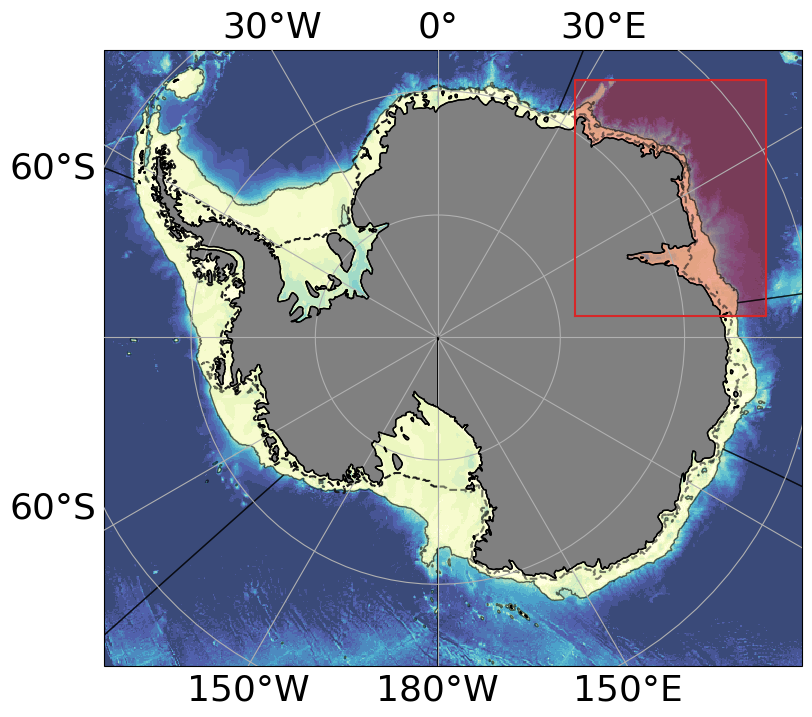

In [55]:
# add the subsect schematic and the legend
# THESE ARE IN GRID POINTS
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1, 1, 1,projection=proj)
plt.rcParams.update({'font.size': 26})

# add bathymetry and ice shelves
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.6)
plt.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.2],
            zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=cmap,alpha=0.6)
plt.contour(dg.lon_rho[1:,:300], dg.lat_rho[1:,:300],ds1.zice[1:,:300],levels=[-0.2],
            zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=cmap)

# add the pcolormesh
xlimit = np.arange(300,560,1)
ylimit = np.arange(350,630,1)
plt.grid()
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=cmap2,alpha=0.8,vmax=4000)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')

# add the gridlines for the subsection
gl = ax.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_extent([-180, 180, -60, -90], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black', facecolor='gray')
print(ax.get_ylim(),ax.get_xlim())
ax.set_xlim([-3052439.3534922358, 3331997.462588497])
ax.set_ylim([-3002747.1802094337, 2626908.379656603])

# add a translucent polygon to show extent
s = np.array([1250000,3000000,3000000,1250000,1250000])
t = np.array([200000,200000,2350000,2350000,200000])
b = np.array([[a,b] for a,b in zip(s,t)])
b = sg.Polygon(b)
x, y = b.exterior.xy
aabw2 = plt.plot(x, y,color="tab:red",zorder=5)
plt.fill(x, y,alpha=0.4,color="tab:red")

# save the figure
plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_5_25/forschematic/extent.png", dpi=300)
# plt.show()

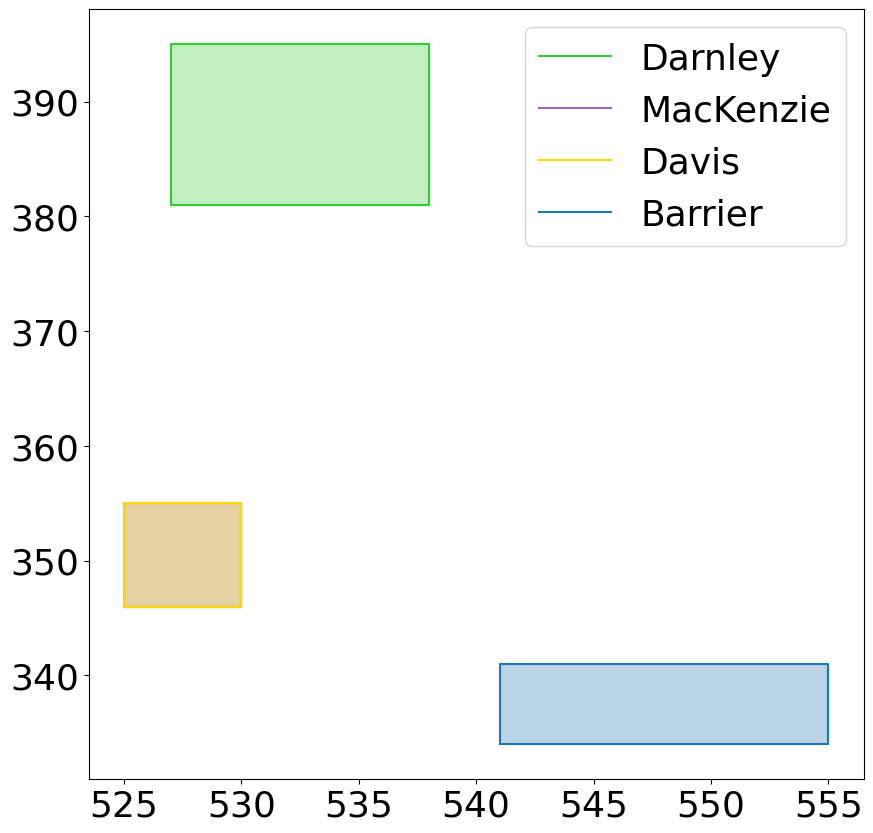

In [59]:
# create also the legend for this plot
# plot all the groups colored by the water mass grid
fig = plt.figure(figsize=(10,10))

# DARNLEY: x[525:540], y[380:400]
sx = np.array([527,538,538,527])
sy = np.array([381,381,395,395])
d = np.array([[a,b] for a,b in zip(sx,sy)])
darnley = sg.Polygon(d)
x, y = darnley.exterior.xy
darnley2 = plt.plot(x, y,label="Darnley",color="limegreen")
plt.fill(x, y,alpha=0.3,color="limegreen")
shapes = np.append(shapes,darnley)
shapelabels = np.append(shapelabels,"Darnley")

# MACKENZIE: x[520:530], y[370,380]
sx = np.array([521,526,526,521])
sy = np.array([370,370,381,381])
m = np.array([[a,b] for a,b in zip(sx,sy)])
mackenzie = sg.Polygon(m)
x, y = davis.exterior.xy
mackenzie2= plt.plot(x, y,label="MacKenzie",color="tab:purple")
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,mackenzie2)
shapelabels = np.append(shapelabels,"MacKenzie")

# DAVIS: x[525:530], y[345:355]
sx = np.array([525,530,530,525])
sy = np.array([346,346,355,355])
da = np.array([[a,b] for a,b in zip(sx,sy)])
davis = sg.Polygon(da)
x, y = davis.exterior.xy
davis2 = plt.plot(x, y,label="Davis",color="gold")
plt.fill(x, y,alpha=0.3,color="gold")
shapes = np.append(shapes,davis2)
shapelabels = np.append(shapelabels,"Davis")

# BARRIER: x[540:560], y[330:342]
shapes = np.array([])
shapelabels = np.array([])
sx = np.array([541,555,555,541])
sy = np.array([334,334,341,341])
b = np.array([[a,b] for a,b in zip(sx,sy)])
barrier = sg.Polygon(b)
x, y = barrier.exterior.xy
barrier2 = plt.plot(x, y,label="Barrier",color="tab:blue")
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,barrier2)
shapelabels = np.append(shapelabels,"Barrier")


plt.legend(loc="best")
plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/meeting_5_25/forschematic/labels.png", dpi=300)